In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

In [2]:
import utils as U
import opt_runs as OR
import opt_model_soln as OM
import decorated_options as Deco

/Users/musically_ut/prog/work/petersburg-2019/redqueen/opt_runs.py:19: UserWarning: broadcast.opt.optimizer was NOT imported. Comparison against method of Karimi et. al. method will not be possible.
  warnings.warn('broadcast.opt.optimizer was NOT imported. '


# Step 1: Create a SimOpts which will generate raw data

In [3]:
sim_opts_1_follower = OM.SimOpts(
    src_id=0,
    end_time=100,
    s=np.array([1]),
    q=1.0,
    other_sources=[('Hawkes', {'src_id': 1, 'seed': 1, 'l_0': 1.0, 'alpha': 1.0, 'beta': 5.0})],
    sink_ids=[1000],
    edge_list=[(0, 1000), (1, 1000)]
)
src_id = sim_opts_1_follower.src_id

# Step 2: Simulate the walls along with different strategies for our broadcaster

### RedQueen

In [4]:
%%time
seed = 1
opt_mgr = sim_opts_1_follower.create_manager_with_opt(seed)
opt_mgr.run_dynamic()
opt_df = opt_mgr.state.get_dataframe()
num_opt_tweets = U.num_tweets_of(opt_df, broadcaster_id=src_id)
perf_opt = {
    'type': 'Opt',
    'seed': seed,
    'capacity': num_opt_tweets,
    'q': sim_opts_1_follower.q,
}
OR.add_perf(perf_opt, opt_df, sim_opts_1_follower)

CPU times: user 114 ms, sys: 16.4 ms, total: 130 ms
Wall time: 144 ms


In [5]:
perf_opt

{'type': 'Opt',
 'seed': 1,
 'capacity': 60.0,
 'q': 1.0,
 'top_1': 60.564200927977325,
 'avg_rank': 54.90032945274162,
 'r_2': 96.66734382976145,
 'world_events': 111,
 'num_events': 60}

### Poisson

In [6]:
%%time
seed = 9
poisson_mgr = sim_opts_1_follower.create_manager_with_poisson(seed, capacity=num_opt_tweets)
poisson_mgr.run_dynamic()
poisson_df = poisson_mgr.state.get_dataframe()
num_poisson_tweets = U.num_tweets_of(poisson_df, broadcaster_id=src_id)
perf_poisson = {
    'type': 'Poisson',
    'seed': seed,
    'capacity': num_poisson_tweets,
    'q': sim_opts_1_follower.q
}
OR.add_perf(perf_poisson, poisson_df, sim_opts_1_follower)

CPU times: user 89.7 ms, sys: 2.82 ms, total: 92.6 ms
Wall time: 95 ms


In [7]:
perf_poisson

{'type': 'Poisson',
 'seed': 9,
 'capacity': 60.0,
 'q': 1.0,
 'top_1': 42.801882649469746,
 'avg_rank': 204.08024707116576,
 'r_2': 1256.2865877657428,
 'world_events': 111,
 'num_events': 60}

### Smart Poisson

In [8]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

rate = num_opt_tweets / T * 4
sp_mgr = sim_opts_1_follower.create_manager_with_smart_poisson(
    seed,
    rate=rate
)

sp_mgr.run_dynamic()
sp_df = sp_mgr.state.get_dataframe()
num_sp_tweets = U.num_tweets_of(sp_df, broadcaster_id=src_id)
perf_sp = {
    'type': 'Smart Poisson',
    'seed': seed,
}
OR.add_perf(perf_sp, sp_df, sim_opts_1_follower)

CPU times: user 63.1 ms, sys: 1.9 ms, total: 65 ms
Wall time: 64.1 ms


In [9]:
perf_sp

{'type': 'Smart Poisson',
 'seed': 24,
 'top_1': 61.3181305094032,
 'avg_rank': 61.472286371388144,
 'r_2': 136.30369011894362,
 'world_events': 111,
 'num_events': 66}

### Piecewise constant

In [10]:
%%time
seed = 24

T = sim_opts_1_follower.end_time

# Keep the rate such that the number of events is roughtly the same as the number of posts
# made by RedQueen, but such that intensity of posting increases with time.
segments = 10
change_times = np.arange(0, segments) * T / segments
rates = np.arange(0, segments) * (2 * num_opt_tweets / T) / (segments - 1)

pwc_mgr = sim_opts_1_follower.create_manager_with_piecewise_const(
    seed, 
    change_times=change_times,
    rates=rates
)

pwc_mgr.run_dynamic()
pwc_df = pwc_mgr.state.get_dataframe()
num_pwc_tweets = U.num_tweets_of(pwc_df, broadcaster_id=src_id)
perf_pwc = {
    'type': 'PWC',
    'seed': seed,
    'capacity': num_pwc_tweets,
}
OR.add_perf(perf_pwc, pwc_df, sim_opts_1_follower)

CPU times: user 80.1 ms, sys: 4.84 ms, total: 84.9 ms
Wall time: 81.9 ms


In [11]:
perf_pwc

{'type': 'PWC',
 'seed': 24,
 'capacity': 61.0,
 'top_1': 34.23988664060658,
 'avg_rank': 521.141391065357,
 'r_2': 9338.652496069519,
 'world_events': 111,
 'num_events': 61}

### Hawkes

In [12]:
%%time
seed = 489

T = sim_opts_1_follower.end_time
l_0, alpha, beta = 0.5, 0.5, 1.0
hawkes_broadcaster = OM.Hawkes(src_id=src_id, l_0=l_0, alpha=alpha, beta=beta, seed=seed)

hawkes_mgr = sim_opts_1_follower.create_manager_with_broadcaster(hawkes_broadcaster)

hawkes_mgr.run_dynamic()
hawkes_df = hawkes_mgr.state.get_dataframe()
num_hawkes_tweets = U.num_tweets_of(hawkes_df, broadcaster_id=src_id)
perf_hawkes = {
    'type': 'Hawkes',
    'seed': seed,
    'alpha': alpha,
    'beta': beta,
    'l_0': l_0,
}
OR.add_perf(perf_hawkes, hawkes_df, sim_opts_1_follower)

CPU times: user 114 ms, sys: 2.87 ms, total: 116 ms
Wall time: 117 ms


In [13]:
perf_hawkes

{'type': 'Hawkes',
 'seed': 489,
 'alpha': 0.5,
 'beta': 1.0,
 'l_0': 0.5,
 'top_1': 42.517166198531285,
 'avg_rank': 164.4527793271227,
 'r_2': 908.1392856705268,
 'world_events': 111,
 'num_events': 89}

# Step 3: Study the performance

In [14]:
experiments = {
    'Poisson': poisson_df,
    'Hawkes': hawkes_df,
    'Smart': sp_df,
    'PWC': pwc_df,
    'RedQueen': opt_df,
}

In [15]:
for kind, df in experiments.items():
    print('kind = {}\t\t num_tweets = {}'.format(kind, U.num_tweets_of(opt_df, src_id)))

kind = Poisson		 num_tweets = 60.0
kind = Hawkes		 num_tweets = 60.0
kind = Smart		 num_tweets = 60.0
kind = PWC		 num_tweets = 60.0
kind = RedQueen		 num_tweets = 60.0


In [16]:
for kind, df in experiments.items():
    print('kind = {}\t\t avg_rank = {}'
          .format(kind, U.average_rank(df, sim_opts=sim_opts_1_follower)))

kind = Poisson		 avg_rank = 204.08024707116576
kind = Hawkes		 avg_rank = 164.4527793271227
kind = Smart		 avg_rank = 61.472286371388144
kind = PWC		 avg_rank = 521.141391065357
kind = RedQueen		 avg_rank = 54.90032945274162


In [17]:
K = 1
for kind, df in experiments.items():
    print('kind = {}\t\t top-{} = {}'
          .format(kind, K, U.time_in_top_k(df, K=K, sim_opts=sim_opts_1_follower)))

kind = Poisson		 top-1 = 42.801882649469746
kind = Hawkes		 top-1 = 42.517166198531285
kind = Smart		 top-1 = 61.3181305094032
kind = PWC		 top-1 = 34.23988664060658
kind = RedQueen		 top-1 = 60.564200927977325


### Rank

In [18]:
def plot_rank_evolution(df, src_id, title=None):
    # plt.figure(figsize=(8,6))
    
    c1, c2 = sns.color_palette(n_colors=2)

    ranks = U.rank_of_src_in_df(df, src_id).mean(axis=1)
    
    fig, ax1 = plt.subplots()
    
    ax1.fill_between(ranks.index, ranks.values, step='post',
                     color=c1, label=r'$\bar{r}(t)$', alpha=0.5)
    
    ax1.set_ylabel('Rank')
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    ax1.set_ylim(0)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    if title is not None:
        plt.title(title)
    
    plt.tight_layout()

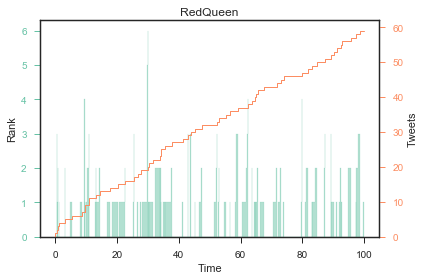

In [19]:
plot_rank_evolution(opt_df, src_id, title='RedQueen')

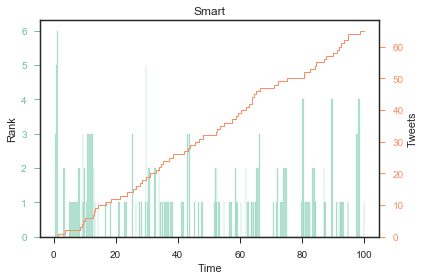

In [20]:
plot_rank_evolution(sp_df, src_id, title='Smart')

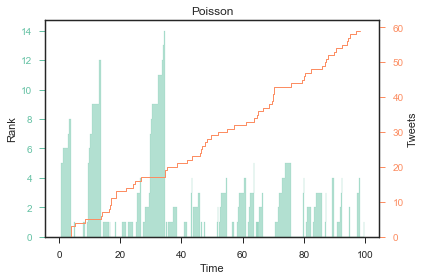

In [21]:
plot_rank_evolution(poisson_df, src_id, title='Poisson')

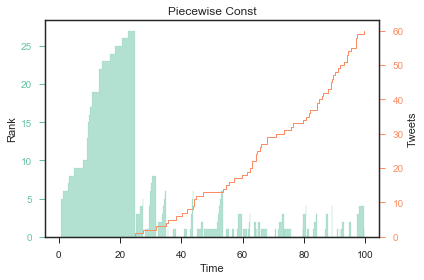

In [22]:
plot_rank_evolution(pwc_df, src_id, title='Piecewise Const')

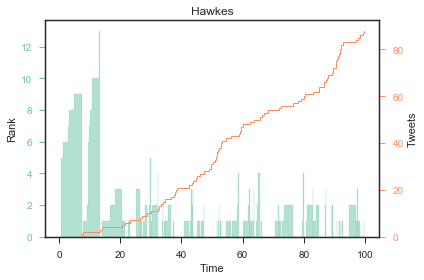

In [23]:
plot_rank_evolution(hawkes_df, src_id, title='Hawkes')

### Top-k

In [24]:
def plot_top_k_evolution(df, src_id, K=1, T=100, ymax=None, title=None):
    # plt.figure(figsize=(8,6))    
    c1, c2 = sns.color_palette(n_colors=2)

    top_k = (U.rank_of_src_in_df(df, src_id) < K).mean(axis=1)
    
    times = np.asarray([0] + top_k.index.values.tolist() + [T])
    t_diff = np.diff(times)
    top_k_indicator = np.array([0] + top_k.values.tolist())

    fig, ax1 = plt.subplots()    

    ax1.fill_between(times[:-1], np.cumsum(top_k_indicator * t_diff), step='post',
                     color=c1, label=r'$1_{[r(t) <= %d]}$' % K,
                     alpha=0.5)
    
    ax1.set_ylabel('Time in Top-{}'.format(K))
    ax1.set_xlabel('Time')
    ax1.tick_params('y', colors=c1)
    
    if ymax is None:
        ax1.set_ylim(0)
    else:
        ax1.set_ylim(0, ymax)
    
    tweet_times = df[(df.src_id == src_id)].t.unique()
    num_tweets = tweet_times.shape[0]
    
    ax2 = ax1.twinx()
    # plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
    ax2.step(tweet_times, np.arange(num_tweets),
             label='$N(t)$', color=c2, linewidth=1.0)
    
    ax2.set_ylabel('Tweets')
    ax2.tick_params('y', colors=c2)
    ax2.set_ylim(0)
    
    if title is not None:
        plt.title(title)
        
    plt.tight_layout()

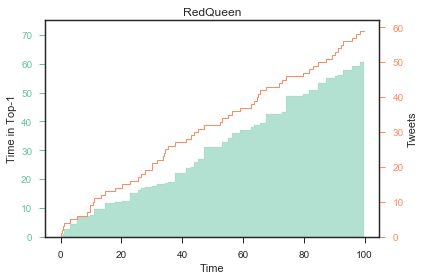

In [25]:
plot_top_k_evolution(opt_df, src_id, ymax=75, title='RedQueen')

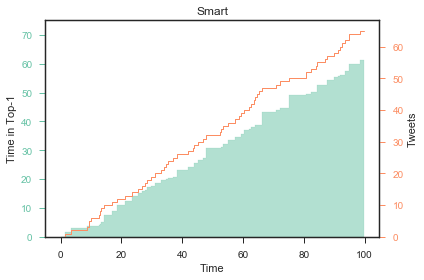

In [26]:
plot_top_k_evolution(sp_df, src_id, ymax=75, title='Smart')

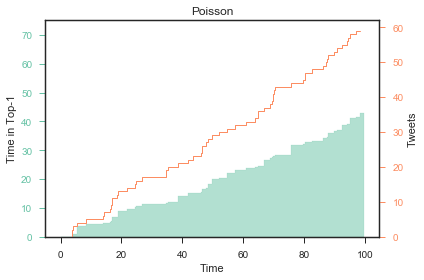

In [27]:
plot_top_k_evolution(poisson_df, src_id, ymax=75, title='Poisson')

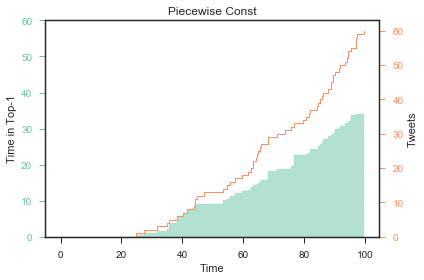

In [28]:
plot_top_k_evolution(pwc_df, src_id, ymax=60, title='Piecewise Const')

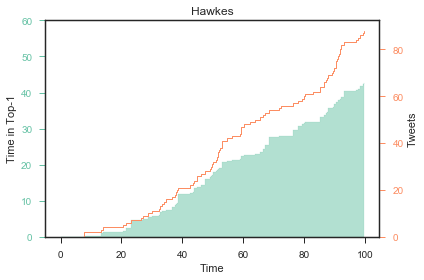

In [29]:
plot_top_k_evolution(hawkes_df, src_id, ymax=60, title='Hawkes')